In [1]:
%matplotlib inline
import grale.lenses as lenses
import grale.plotutil as plotutil
import grale.feedback as feedback
import grale.renderers as renderers
import grale.cosmology as cosmology
import grale.inversion as inversion
import grale.images as images
import grale.util as util
from grale.constants import *

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import os
import pickle
import pprint

V = lambda x, y: np.array([x,y], dtype=np.double)

cosm = cosmology.Cosmology(0.7, 0.3, 0, 0.7)
cosmology.setDefaultCosmology(cosm)

feedback.setDefaultFeedback("notebook")
renderers.setDefaultLensPlaneRenderer("threads")
renderers.setDefaultMassRenderer("threads")
plotutil.setDefaultAngularUnit(ANGLE_ARCSEC)

plt.rcParams.update({'font.size': 12})

In [2]:
realLensFile = "reallens.lensdata"

zd = 0.4
zs = 1.5
Dd = cosm.getAngularDiameterDistance(zd)
critDens = lenses.getCriticalDensity(Dd, cosm.getAngularDiameterDistance(zs),
                                     cosm.getAngularDiameterDistance(zd, zs))

strongSize = 100*ANGLE_ARCSEC
smallSize, smallCenter = 12*ANGLE_ARCSEC, V(-4,-18)*ANGLE_ARCSEC

imgList = images.readInputImagesFile("images.txt", True) # The last one is the special one, with extra splitting

def getAllImagePoints(imgList):
    pts = []
    for i in imgList:
        imgDat = i["imgdata"] if type(i) is dict else i
        for img in imgDat.getAllImagePoints():
            for p in img:
                pts.append(p["position"])
    return np.array(pts)/ANGLE_ARCSEC

def getFirstImagePoints(imgList):
    pts = []
    for i in imgList:
        imgDat = i["imgdata"] if type(i) is dict else i
        for img in imgDat.getAllImagePoints()[:1]:
            for p in img:
                pts.append(p["position"])
                
    return np.array(pts)/ANGLE_ARCSEC

allInputPoints = getAllImagePoints(imgList)
allExceptQuadPoints = getAllImagePoints(imgList[:-1])
quadPoints = getAllImagePoints(imgList[-1:])

In [3]:
liCache = { }

In [4]:
def getCacheFileName(hsh):
    return "licache_" + hsh + ".pickle"

def getLIEntry(fileName):
    import hashlib
    data = open(fileName, "rb").read()
    s = hashlib.sha256()
    s.update(data)
    h = s.hexdigest()
    if h in liCache:
        return liCache[h]

    cfn = getCacheFileName(h)
    #print(cfn)
    if os.path.exists(cfn):
        liCache[h] = pickle.load(open(cfn, "rb"))
        assert(h == liCache[h]["hash"])
        return liCache[h]

    lens = lenses.GravitationalLens.load(fileName)
    liNarrow = plotutil.LensInfo(lens, size=strongSize, zd=zd, cosmology=cosm) 
    liSmall = plotutil.LensInfo(lens, zd=zd, size=smallSize, center=smallCenter, cosmology=cosm)
    liMulti = plotutil.LensInfo([(lens,zd)], size=strongSize, cosmology=cosm)
    d = { "narrow": liNarrow, "small": liSmall, "multi": liMulti, "filename": fileName, "hash": h, "lens": lens }
    liCache[h] = d
    return d
    
def saveCaches():
    for n in liCache:
        print(n, liCache[n]["filename"])
        cfn = getCacheFileName(n)
        pickle.dump(liCache[n], open(cfn,"wb"))

In [5]:
def createInputPointsPlot():
    plt.plot(allExceptQuadPoints[:,0], allExceptQuadPoints[:,1], '.', color="black", markersize=2)
    plt.plot(quadPoints[:,0], quadPoints[:,1], '.', color="black", markersize=10)
    plt.gca().set_aspect("equal")
    
def saveFig(fn):
    plt.savefig(fn, bbox_inches="tight")

In [6]:
def createMassPlot(fn, subsize="39%", subloc=4, title=None, pred=True):
    li = getLIEntry(fn)
    plotutil.plotDensityContours(li["narrow"], densityUnit=critDens, levels=np.linspace(0,4, 17), colors="grey")
    plotutil.plotDensityContours(li["narrow"], densityUnit=critDens, levels=[1], colors="black", linewidths=3)
    plt.gca().set_xlabel("X (arcsec)")
    plt.gca().set_ylabel("Y (arcsec)")
    plt.gca().invert_xaxis()
    if title:
        plt.gca().set_title(title)
    
    if pred: 
        plotPredictions(fn)
    else:
        createInputPointsPlot()
    
    ax = inset_axes(plt.gca(), width=subsize, height=subsize, loc=subloc)
    plotutil.plotDensityContours(li["small"], densityUnit=critDens, levels=np.linspace(0,4, 17), colors="grey", axes=ax)
    plotutil.plotDensityContours(li["small"], densityUnit=critDens, levels=[1], colors="black", linewidths=3, axes=ax)
    ax.invert_xaxis()
    ax.set_xticks([])
    ax.set_yticks([])
    
    if pred: 
        plotPredictions(fn)
    else:
        createInputPointsPlot()
    

def getCenter(pts):
    minx, maxx = np.min(pts[:,0]), np.max(pts[:,0])
    miny, maxy = np.min(pts[:,1]), np.max(pts[:,1])
    return V((minx+maxx)/2, (miny+maxy)/2)
    
def getIWS(last = "all"):
    iws = inversion.InversionWorkSpace(zd, strongSize, cosmology=cosm)
    if last == "all":
        imgs = imgList
    elif last == "only":
        imgs = imgList[-1:]
    elif last == "exclude":
        imgs = imgList[:-1]
    for i in imgs:
        iws.addImageDataToList(i["imgdata"], i["z"], "pointimages")
    return iws

def drawFilledCircles(centers, size):
    for ctr in centers:
        c = plt.Circle(ctr, radius=size/2 , color="#bbbbbb")
        plt.gca().add_artist(c)

def createBackprojectPlot(fn, realToo = False):

    li = getLIEntry(fn)
    if realToo:
        iws = getIWS()
        targetCenter = getCenter(getAllImagePoints(iws.backProject(li["lens"])))
        
        liReal = getLIEntry("reallens.lensdata")
        pts = getAllImagePoints(iws.backProject(liReal["lens"]))
        realCenter = getCenter(pts)
        pts -= realCenter
        pts += targetCenter
        #plt.plot(pts[:,0], pts[:,1], 'o', markersize=15, markeredgecolor="none", markerfacecolor="#00000030")
        
        
        plt.plot(pts[:,0], pts[:,1], 'o', markersize=0.1, markeredgecolor="none", markerfacecolor="#bbbbbb")
        drawFilledCircles(pts, 1)
        
        lr, tb = plt.xlim(), plt.ylim()
        plt.gca().set_xlim(lr)
        plt.gca().set_ylim(tb)
        plt.plot([-100], [-100], 'o', markersize=7.5, markeredgecolor="none", markerfacecolor="#bbbbbb",
                 label="True positions (offset)")
        lambd = estimateLambdaFromBP(fn)
        plt.plot([],[],".",color="white",label=r"$\lambda_{{\rm est}}$ = {:.02f}".format(lambd))

        plt.legend()
    
    for t,m,ms in [ ("exclude", ".", 2), ("only", ".", 10)]:
        iws = getIWS(t)
        bpImgs = iws.backProject(li["lens"])
        pts = getAllImagePoints(bpImgs)
        plt.plot(pts[:,0], pts[:,1], m, markersize=ms, color="black")
        center = getCenter(pts)
    
    ylim = plt.gca().get_ylim()
    plt.gca().set_ylim(top = ylim[1]+5)
    plt.gca().set_aspect("equal")
        
    plt.gca().set_xlabel("X (arcsec)")
    plt.gca().set_ylabel("Y (arcsec)")
    plt.gca().invert_xaxis()

def createCritLinesPlot(fn, title=None):

    ax = plt.gca()
    plt.gca().set_xlabel("X (arcsec)")
    plt.gca().set_ylabel("Y (arcsec)")
    if title:
        plt.gca().set_title(title)

    for t in ["narrow", "small"]:
        for n, s, lw in [ ("reallens.lensdata", "-", 1), (fn, "-", 2)]:
            li = getLIEntry(n)
            li[t].setSourceRedshift(zs)
            plotutil.plotImagePlane(li[t], bgRgb=(0,0,0,0), critColor="black", 
                                    critKw={ "linestyle": s, "linewidth": lw }, plotCaustics=False, axes=ax)
            
        ax.invert_xaxis()
        if t == "narrow":
            ax = inset_axes(plt.gca(), width="39%", height="39%", loc=4)
            ax.set_yticks([])
            ax.set_xticks([])

def plotPredictions(fn, imgs=imgList):
    li = getLIEntry(fn)
    pred = util.calculateImagePredictions(imgs, li["lens"], cosmology=cosm)
    #pred = util.calculateImagePredictions(imgs, li["multi"].getLensPlane())

    for src in pred:
        for img in src:
            plt.plot(img["theta_obs"][0]/ANGLE_ARCSEC,img["theta_obs"][1]/ANGLE_ARCSEC,'x',color="black")
            plt.plot(img["theta_pred"][0][0]/ANGLE_ARCSEC,img["theta_pred"][0][1]/ANGLE_ARCSEC,'o',color="black",markerfacecolor="none")



In [7]:
def getSize(pts):
    minx, maxx = np.min(pts[:,0]), np.max(pts[:,0])
    miny, maxy = np.min(pts[:,1]), np.max(pts[:,1])
    return V((-minx+maxx), (-miny+maxy))

def getDiag(dx, dy):
    return (dx**2+dy**2)**0.5

def estimateLambdaFromBP(fn):
    li = getLIEntry(fn)
    liReal = getLIEntry(realLensFile)
    iws = getIWS()
    bpImgs = getAllImagePoints(iws.backProject(li["lens"]))
    bpReal = getAllImagePoints(iws.backProject(liReal["lens"]))
    
    reconstr = getDiag(*getSize(bpImgs))
    real = getDiag(*getSize(bpReal))
    return reconstr/real

/home/jori/anaconda3-201812/envs/grale2env201812/lib/python3.7/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/home/jori/anaconda3-201812/envs/grale2env201812/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


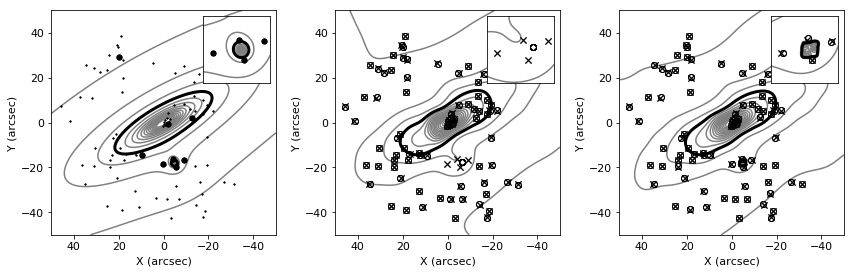

In [8]:
plt.rcParams.update({'font.size': 11})
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
createInputPointsPlot()
createMassPlot("reallens.lensdata", "30%", 1, pred=False)
createInputPointsPlot()

plt.subplot(1,3,2)
fn = "avg-rms_no-null_yes-smallnull_no-sr_0-su_0-sm_0.lensdata"
plotPredictions(fn)
createMassPlot(fn, "30%", 1)
plotPredictions(fn)

plt.subplot(1,3,3)
fn = "avg-rms_no-null_yes-smallnull_yes-sr_2.5-su_15-sm_1e10.lensdata"
plotPredictions(fn)
createMassPlot(fn, "30%", 1)
plotPredictions(fn)

plt.tight_layout()

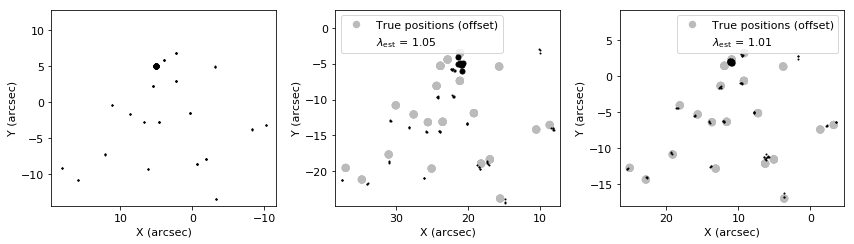

In [9]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
createBackprojectPlot("reallens.lensdata")
    
plt.subplot(1,3,2)
createBackprojectPlot("avg-rms_no-null_yes-smallnull_no-sr_0-su_0-sm_0.lensdata", True)

plt.subplot(1,3,3)
createBackprojectPlot("avg-rms_no-null_yes-smallnull_yes-sr_2.5-su_15-sm_1e10.lensdata", True)

plt.tight_layout()

In [10]:
quadImgData = images.ImagesData(4)
quadDist = [ ]
for i, pos in zip(range(4),quadPoints[:4]):
    quadImgData.addPoint(i, pos*ANGLE_ARCSEC)
    dist = sum(pos**2)**0.5
    quadDist.append(dist)

In [11]:
def horCoordFunction(xy):
    return np.sum(xy**2)**0.5

def plotQuadPos():
    ymax = plt.ylim()[1]
    for qd in quadDist:
        plt.plot([qd,qd],[0,ymax], ':', color="gray")
    plt.gca().set_ylim([0, ymax])

def plotDensAtPosRel(fn, ax = None):
    ax = plt.gca() if ax is None else ax

    savedRealDens = { }
    def saveDens(l, pos, img):
        x = l.getSurfaceMassDensity(pos)
        savedRealDens[tuple(pos)] = x
        return x    
    plotutil.plotDensitiesAtImagePositions(getLIEntry(realLensFile)["lens"], imgList, marker="x", horCoordFunction=horCoordFunction, axes=False, densFunction=saveDens)
    
    def fracDens(l, pos, imgIdx):
        densReal = savedRealDens[tuple(pos)]
        x = l.getSurfaceMassDensity(pos)
        return x/densReal

    plotutil.plotDensitiesAtImagePositions(getLIEntry(fn)["lens"], imgList, horCoordFunction=horCoordFunction, axes=ax, densFunction=fracDens)
    
    ax.set_ylabel("$\kappa/\kappa_R$")
    plotQuadPos()

def plotDensAtPos(fn, ax = None):
    ax = plt.gca() if ax is None else ax
    plotutil.plotDensitiesAtImagePositions(getLIEntry(fn)["lens"], imgList, densityUnit=critDens, label="Reconstructed density", horCoordFunction=horCoordFunction, axes=ax)
    plotutil.plotDensitiesAtImagePositions(getLIEntry(realLensFile)["lens"], imgList, densityUnit=critDens, label="True density", marker="x", horCoordFunction=horCoordFunction, axes=ax)
    plt.legend()
    ax.set_xlabel("Distance from main NSIE center (arcsec)")
    ax.set_ylabel("$\kappa$")

    plotQuadPos()
 
    ax = inset_axes(ax, width="39%", height="39%", loc=7)
    ax.set_xlim([16,21])
    plotutil.plotDensitiesAtImagePositions(getLIEntry(fn)["lens"], imgList, densityUnit=critDens, label="Reconstructed density", horCoordFunction=horCoordFunction)
    plotutil.plotDensitiesAtImagePositions(getLIEntry(realLensFile)["lens"], imgList, densityUnit=critDens, label="True density", marker="x", horCoordFunction=horCoordFunction)
    plotQuadPos()
    ax.set_ylim([0.5,1.0])

def addBar(a):
    plt.colorbar(a, fraction=0.046, pad=0.04)

def plotFracRelDens2D(fn, ax=None):
    ax = plt.gca() if ax is None else ax
    li = getLIEntry(fn)["narrow"]
    liReal = getLIEntry(realLensFile)["narrow"]
    
    dens, densReal = li.getDensityPoints(), liReal.getDensityPoints()
    frac = dens/densReal
    area = li.getArea()
    
    di = plotutil.DensInfo(frac, **area)
    clevels = [0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5]
    norm= colors.BoundaryNorm(clevels, 256)
    plotutil.plotDensity(di,axImgCallback=addBar, cmap="bwr_r", norm=norm)
    plotutil.plotDensityContours(di, levels=[0.9, 1.1], colors="black", linewidths=[0.75], linestyles=["-","-"])
    ax.set_title("$\kappa/\kappa_R$")
    
def getMagFromLensPlane(lp, dfrac):
    r = lp.getAlphaVectorDerivatives()
    axx, ayy, axy = r["alpha_xx"]*dfrac, r["alpha_yy"]*dfrac, r["alpha_xy"]*dfrac
    invMag = (1.0-axx)*(1.0-ayy)-axy*axy
    return 1.0/invMag

def plotFracRelMag2D(fn, ax=None):
    ax = plt.gca() if ax is None else ax
    li = getLIEntry(fn)["narrow"]
    liReal = getLIEntry(realLensFile)["narrow"]
    
    zs = 9
    Ds, Dds = cosm.getAngularDiameterDistance(zs), cosm.getAngularDiameterDistance(zd,zs)
    
    mu = getMagFromLensPlane(li.getLensPlane(), Dds/Ds)
    muReal = getMagFromLensPlane(liReal.getLensPlane(), Dds/Ds)
    
    frac = np.log10(abs(mu/muReal))
    #frac = abs(mu/muReal)
    area = li.getArea()
    
    di = plotutil.DensInfo(frac, **area)
    #clevels = [-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1]
    clevels = [-0.9,-0.7,-0.5,-0.3,-0.1,0.1,0.3,0.5,0.7,0.9]
    #clevels = [-1,-0.6,-0.2,0.2,0.6,1]
    norm= colors.BoundaryNorm(clevels, 256)
    plotutil.plotDensity(di,axImgCallback=addBar, cmap="bwr_r",vmin=-1,vmax=1, norm=norm)
    #plotutil.plotDensityContours(di, levels=[-0.2, 0.2], colors="black", linewidths=[0.75], linestyles=["-","-"])

    ax.set_title("$\log_{10}|\mu/\mu_R|$")

Text(value='')

Text(value='')

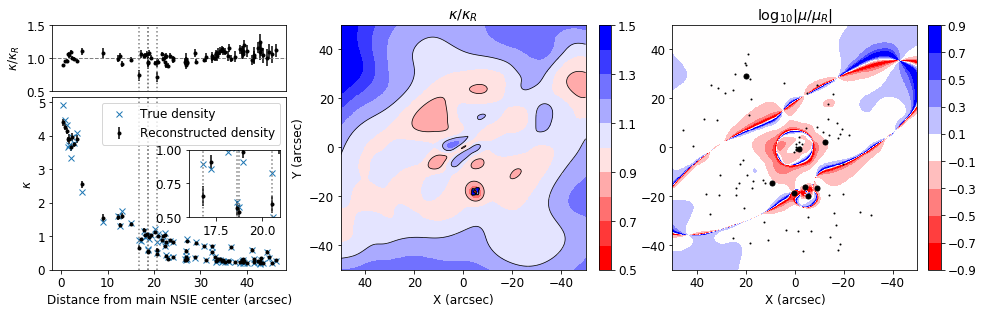

In [12]:
def plotRelQuant():
    plt.figure(figsize=(13,4))
    fig = plt.gcf()
    
    x0, xw = 0.05, 0.25
    ax = fig.add_axes([ x0, 0.72, xw, 0.23], xticks=[])
    
    ax.set_ylim([0.5,1.5])
    plotDensAtPosRel("avg-rms_no-null_yes-smallnull_yes-sr_2.5-su_15-sm_1e10.lensdata", ax)
    ax.set_ylim([0.5,1.5])
    
    xlimits = ax.get_xlim()
    ax.plot([-10,60],[1,1],'--',color="gray", lw=1)
    ax.set_xlim(*xlimits)
    
    ax = fig.add_axes([ x0, 0.1, xw, 0.6])
    plotDensAtPos("avg-rms_no-null_yes-smallnull_yes-sr_2.5-su_15-sm_1e10.lensdata", ax)

    x0, xw = 0.3, 0.35
    ax = fig.add_axes([ x0, 0.1, xw, 0.85])
    plotFracRelDens2D("avg-rms_no-null_yes-smallnull_yes-sr_2.5-su_15-sm_1e10.lensdata", ax)
    ax.invert_xaxis()
    ax.set_xlabel("X (arcsec)")
    ax.set_ylabel("Y (arcsec)")
    
    x0, xw = 0.7, 0.3
    ax = fig.add_axes([ x0, 0.1, xw, 0.85])
    plotFracRelMag2D("avg-rms_no-null_yes-smallnull_yes-sr_2.5-su_15-sm_1e10.lensdata", ax)
    ax.invert_xaxis()
    ax.set_xlabel("X (arcsec)")
    #ax.set_ylabel("Y (arcsec)")
    
    createInputPointsPlot()

plt.rcParams.update({'font.size': 12})

plotRelQuant()

Text(value='')

Text(value='')

Text(value='')

Text(value='')

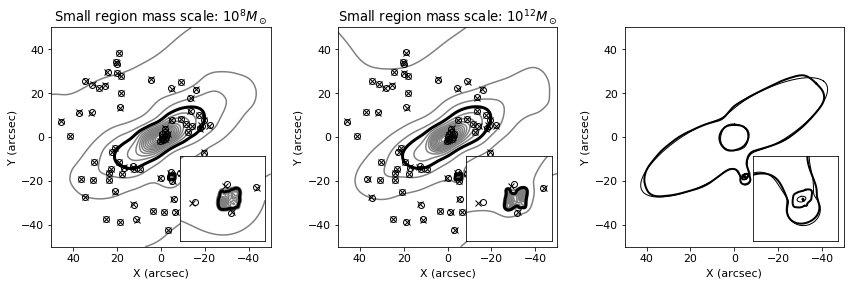

In [13]:
plt.rcParams.update({'font.size': 11})
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
createMassPlot("avg-rms_no-null_yes-smallnull_yes-sr_2.5-su_15-sm_1e8.lensdata", title="Small region mass scale: $10^8 M_\odot$")
plt.subplot(1,3,2)
createMassPlot("avg-rms_no-null_yes-smallnull_yes-sr_2.5-su_15-sm_1e12.lensdata", title="Small region mass scale: $10^{12} M_\odot$")
plt.subplot(1,3,3)
createCritLinesPlot("avg-rms_no-null_yes-smallnull_yes-sr_2.5-su_15-sm_1e10.lensdata")
plt.tight_layout()

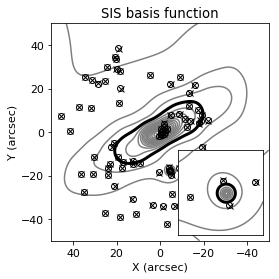

In [14]:
plt.rcParams.update({'font.size': 11})
createMassPlot("avgsis-rms_yes-null_no-smallnull_no-sisx_-4.8-sisy_-18.1-sisdisp_100000.lensdata", 
               title="SIS basis function")

In [15]:
def getRMSValues(fn, imgs=imgList):
    li = getLIEntry(fn)
    pred = util.calculateImagePredictions(imgs, li["lens"], cosmology=cosm)
    
    values = []
    idx = 0
    for sourceImages in pred:
        idx += 1
        RMS = 0
        for img in sourceImages:
            diff = (img["theta_obs"] - img["theta_pred"])/ANGLE_ARCSEC
            RMS += np.sum(diff**2)
            
        RMS /= len(sourceImages)
        RMS = RMS**0.5

        values.append(RMS)
        print(f"Source {idx}: {RMS:.02f} arcsec")
    
    return values

In [16]:
rmsWithout = getRMSValues("avg-rms_no-null_yes-smallnull_no-sr_0-su_0-sm_0.lensdata")

Source 1: 0.17 arcsec
Source 2: 0.22 arcsec
Source 3: 0.16 arcsec
Source 4: 0.25 arcsec
Source 5: 0.27 arcsec
Source 6: 0.12 arcsec
Source 7: 0.11 arcsec
Source 8: 0.14 arcsec
Source 9: 0.17 arcsec
Source 10: 0.07 arcsec
Source 11: 0.32 arcsec
Source 12: 0.41 arcsec
Source 13: 0.23 arcsec
Source 14: 0.14 arcsec
Source 15: 0.19 arcsec
Source 16: 0.11 arcsec
Source 17: 0.25 arcsec
Source 18: 0.10 arcsec
Source 19: 0.08 arcsec
Source 20: 2.83 arcsec


In [17]:
rmsWith = getRMSValues("avg-rms_no-null_yes-smallnull_yes-sr_2.5-su_15-sm_1e10.lensdata")

Source 1: 0.24 arcsec
Source 2: 0.19 arcsec
Source 3: 0.15 arcsec
Source 4: 0.26 arcsec
Source 5: 0.20 arcsec
Source 6: 0.15 arcsec
Source 7: 0.09 arcsec
Source 8: 0.14 arcsec
Source 9: 0.15 arcsec
Source 10: 0.08 arcsec
Source 11: 0.32 arcsec
Source 12: 0.42 arcsec
Source 13: 0.18 arcsec
Source 14: 0.17 arcsec
Source 15: 0.14 arcsec
Source 16: 0.08 arcsec
Source 17: 0.15 arcsec
Source 18: 0.17 arcsec
Source 19: 0.06 arcsec
Source 20: 0.22 arcsec


In [23]:
#saveCaches()